In [1]:
from dictionary_learning.trainers.top_k import AutoEncoderTopK
import torch
from utils import MODELS_DIR, INPUT_DATA_DIR
from datasets import load_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

device = "cuda:1"
model_name = "facebook/musicgen-medium"
max_tokens = 200
base_dir = INPUT_DATA_DIR / "music-bench" / "datashare-instruments"
model_sr = 32000

In [3]:
ae = AutoEncoderTopK.from_pretrained(
    MODELS_DIR / "medium-sae-trivial-medium-sae-ee3b" / "16" / "trainer_0" / "checkpoints" / "ae_71100.pt"
).to(device)


def get_dl(name, batch_size=200000, n=1000):
    ds = load_dataset(
        "arrow",
        data_files=str(INPUT_DATA_DIR / name / "medium" / "jamendo_plugin" / "16" / "train" / "*.arrow"),
        # streaming=True,
        split="train",
    ).select(range(n))

    def collate_fn(batch, device):
        activations = torch.tensor([item["activation"] for item in batch])
        return activations.squeeze()

    return DataLoader(
        ds,
        batch_size=batch_size,
        # num_workers=,
        collate_fn=lambda x: collate_fn(x, device),
    )


# dl = get_dl("raggae_activation", batch_size=1000)
# not_dl = get_dl("anty_raggae_activation", batch_size=1000)

In [3]:
# col_sum = None  # (W,)
# total_sum = torch.tensor(0.0, dtype=torch.float64, device=device)
# n_rows = 0

# with torch.no_grad():  # stats only
#     for x in tqdm(dl):  # x: (B, W)
#         x = x.to(device)
#         x = ae.encode(x)
#         if col_sum is None:
#             W = x.size(1)
#             col_sum = torch.zeros(W, dtype=torch.float64, device=device)
#         col_sum += x.sum(dim=0, dtype=torch.float64)  # per-feature sum
#         total_sum += x.sum(dtype=torch.float64)  # global sum
#         n_rows += x.size(0)

# # Dataset-wide per-feature mean (W,) and global scalar mean
# mu = col_sum / n_rows  # (W,)
# global_mean = total_sum / (n_rows * mu.numel())  # scalar

# # Final normalized vector (W,)
# mu = mu.to(torch.float32)  # or your x.dtype
# den = global_mean.to(mu.dtype) + torch.finfo(mu.dtype).eps
# out = mu / den

100%|██████████| 5/5 [03:03<00:00, 36.69s/it]


In [4]:
# torch.save(out.detach().cpu(), INPUT_DATA_DIR / "unlearn" / "raggae1.pt")
# torch.save(mu.detach().cpu(), INPUT_DATA_DIR / "unlearn" / "raggae1_mu.pt")

In [8]:
raggae_out = torch.load(INPUT_DATA_DIR / "unlearn" / "raggae.pt")
raggae_mu = torch.load(INPUT_DATA_DIR / "unlearn" / "raggae_mu.pt")
anty_raggae_out = torch.load(INPUT_DATA_DIR / "unlearn" / "anty_raggae.pt")

tensor(23.1463)

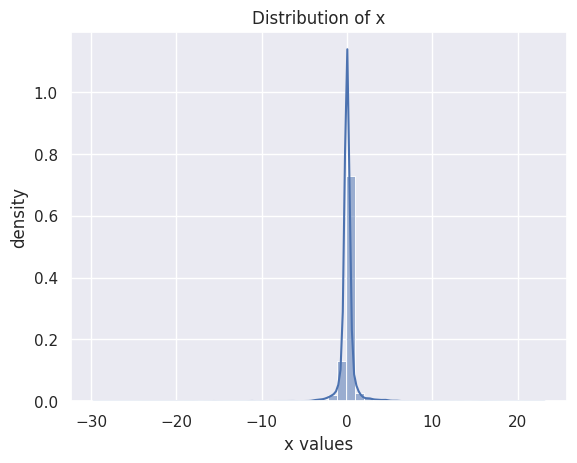

In [16]:
vals = (raggae_out - anty_raggae_out).detach().float().cpu().numpy().ravel()  # 1D array of all values

sns.set_theme()
sns.histplot(vals, bins=50, stat="density", kde=True)
plt.xlabel("x values")
plt.ylabel("density")
plt.title("Distribution of x")
plt.show()

100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


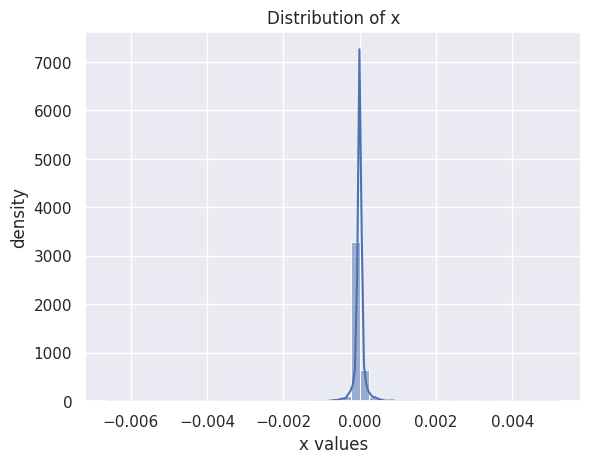

In [32]:
@torch.no_grad()
def batch_score_vector(loader_c, loader_nc, delta: float = 1e-8, delta_prime: float | None = None, device=None):
    if delta_prime is None:
        delta_prime = delta

    def _accumulate(loader):
        col_sum = None  # (n,)
        count = 0
        for batch in tqdm(loader):
            # allow loaders that yield (X, y, ...) tuples
            X = batch[0] if isinstance(batch, (tuple, list)) else batch
            if device is not None:
                X = X.to(device, non_blocking=True)
            X = ae.encode(X)
            X = X.float()
            if col_sum is None:
                col_sum = torch.zeros(X.size(1), dtype=torch.float64, device=X.device)
            col_sum += X.sum(dim=0, dtype=torch.float64)
            count += X.size(0)
        return col_sum, count

    col_sum_c, Lc = _accumulate(loader_c)
    col_sum_nc, Lnc = _accumulate(loader_nc)

    if Lc == 0 or Lnc == 0:
        raise ValueError("Empty dataset in one of the loaders.")

    mu_c = (col_sum_c / Lc).to(torch.float32)  # (n,)
    mu_nc = (col_sum_nc / Lnc).to(torch.float32)  # (n,)

    denom_c = mu_c.sum() + float(delta)
    denom_nc = mu_nc.sum() + float(delta_prime)

    return mu_c / denom_c - mu_nc / denom_nc, mu_c, mu_nc


batch_size, n = 10000, 100000
score, mu_c, mu_nc = batch_score_vector(
    get_dl("raggae_activation", batch_size, n), get_dl("anty_raggae_activation", batch_size, n), device=device
)
vals = score.detach().float().cpu().numpy().ravel()  # 1D array of all values

sns.set_theme()
sns.histplot(vals, bins=50, stat="density", kde=True)
plt.xlabel("x values")
plt.ylabel("density")
plt.title("Distribution of x")
plt.show()

In [46]:
torch.save(score.detach().cpu(), INPUT_DATA_DIR / "unlearn" / "raggae.pt")
torch.save(mu_c.detach().cpu(), INPUT_DATA_DIR / "unlearn" / "raggae_mu.pt")

In [45]:
score

tensor([1.3452e-07, 1.4490e-06, 2.0092e-07,  ..., 1.0705e-04, 3.1713e-07,
        1.9401e-05], device='cuda:1')

In [38]:
q = 0.99
thr = torch.quantile(score.float(), q).cpu()
x = score.detach().cpu()
x[x > thr] = -100
ind = x.topk(100).indices
mask = torch.zeros(x.shape[0])
mask[ind] = 1
intervention_mask = mu_c.detach().cpu()
intervention_mask[~mask.bool()] = 1
intervention_mask

In [44]:
intervention_mask = mu_c.detach().cpu()
intervention_mask[~mask.bool()] = 1
intervention_mask

tensor([1., 1., 1.,  ..., 1., 1., 1.])